# Notebook to process mass spectrometry data from the MassBank of North America (MoNA) database.

Data file is .sdf format, each chemical sample is a rdkit Chem.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit import RDLogger

# suppress rdkit error messages
RDLogger.logger().setLevel(RDLogger.CRITICAL)

In [2]:
file_path = '/home/cmdunham/ChemicalDataGeneration/MoNA_data/MoNA-export-Experimental_Spectra.sdf'
original_suppl = Chem.SDMolSupplier(file_path)

# Function Defs:
---


In [3]:
def make_SDMOLSupplier_with_specified_properties(suppl, specified_props):
    """
    Create a new SDMolSupplier containing only the molecules containing all the specified properties.

    Args:
        suppl (Chem.SDMolSupplier): The SDMolSupplier containing the molecules.
        specified_props (list): A list of property names to check for in the molecules.

    Returns:
        Chem.SDMolSupplier: A new SDMolSupplier containing only the molecules with the specified properties.
    """
    new_suppl = []  # Create a new list to store the filtered molecules
    
    # Iterate through the input supplier
    for mol in suppl:
        # Check if the molecule is not None and has all the specified properties
        if mol is not None and all(mol.HasProp(prop) for prop in specified_props):
            new_suppl.append(mol)  # Add the molecule to the new supplier if it meets the criteria
    
    # Create a temporary file path to write the filtered molecules to
    temp_file_path = '/home/cmdunham/ChemicalDataGeneration/MoNA_data/temp_sdf.sdf'
    
    # Open an SDWriter to write the filtered molecules to the temporary file
    with Chem.SDWriter(temp_file_path) as writer:
        for mol in new_suppl:
            writer.write(mol)  # Write each molecule to the temporary file
    
    # Create a new SDMolSupplier from the temporary file and return it
    return Chem.SDMolSupplier(temp_file_path)


In [4]:
def make_property_count_dict(suppl, prop):
    """
    Create a dictionary that counts the occurrences of each unique value for a specified property
    across the molecules in the input supplier.

    Args:
        suppl (Chem.SDMolSupplier): The input supplier containing the molecules.
        prop (str): The name of the property to count.

    Returns:
        prop_count_dict (dict): A dictionary where keys are unique property values and values are
        counts of how many times each value appears.
    """

    prop_count_dict = {}
    for mol in suppl:
        if mol is not None: 
            try:
                # Get the value of the specified property for the current molecule
                prop_instance = mol.GetProp(prop)

                # If the property value is already in the dictionary, increment its count by 1
                if prop_instance in prop_count_dict.keys():
                    prop_count_dict[prop_instance] += 1
                # If the property value is not yet in the dictionary, add it with a count of 1
                else:
                    prop_count_dict[prop_instance] = 1
            except:
                # If the molecule does not have the specified property skip the molecule
                pass

    return prop_count_dict

# Dataset Overview:
---

Some of the samples in the database contain no information. Determining how many of the total samples are usable (contain information), and how many of the usable samples contain InCHIKey identifiers (more information: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4486400/):

For inchikey_count_dict: Counting number of samples for each chemical (as defined by InCHIKey).
For instrument_count_dict: Counting number of spectra generated using each instrument. Only including in this count the spectra that have a listed instrument type.

In [5]:
suppl = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY'])

In [6]:
# creating a list of all of all the properties we can access in the metadata
all_prop_names = set()
for chem in suppl:
    if chem is not None:
        prop_names = chem.GetPropNames()
        all_prop_names.update(prop_names)

all_prop_names = list(all_prop_names)
all_prop_names

['SYNONYMS',
 'SPECTRUM TYPE',
 'NAME',
 'INSTRUMENT TYPE',
 'FORMULA',
 'ION MODE',
 'INSTRUMENT',
 'ID',
 'COMMENT',
 'NUM PEAKS',
 'MASS SPECTRAL PEAKS',
 'PRECURSOR TYPE',
 'CONTRIBUTOR',
 'COLLISION ENERGY',
 'INCHIKEY',
 'EXACT MASS',
 'MW',
 'PRECURSOR M/Z']

In [7]:
inchikey_count_dict = make_property_count_dict(suppl, 'INCHIKEY')

In [8]:
total_samples = 0
usable_samples = 0
usable_samples_w_inchikey = 0

for chem in suppl:
    total_samples += 1
    if chem is not None:
        usable_samples += 1
        try:                
            if chem.GetProp('INCHIKEY'):
                usable_samples_w_inchikey += 1

        except:
            pass

In [9]:
print('Number of samples in the database:')
print(f'    Total samples - {total_samples:,}')
print(f'    Valid samples - {usable_samples:,}')
print(f'    Valid samples with InCHIKey - {usable_samples_w_inchikey:,}')

Number of samples in the database:
    Total samples - 139,929
    Valid samples - 139,929
    Valid samples with InCHIKey - 139,929


In [10]:
print(f'Of the total {total_samples:,} samples in the database, {usable_samples_w_inchikey:,}, or {round((usable_samples_w_inchikey/total_samples)*100)}%, are usable samples with InCHIKey identifiers.')

Of the total 139,929 samples in the database, 139,929, or 100%, are usable samples with InCHIKey identifiers.


In [11]:
threshold = 10

total_usable_spectra = 0
num_chems = 0

inchikeys_for_chems_past_threshold = []

for chem in inchikey_count_dict:
    if inchikey_count_dict[chem] >= threshold:
        total_usable_spectra += inchikey_count_dict[chem]
        num_chems += 1
        inchikeys_for_chems_past_threshold.append(chem)

print(f'There are {num_chems:,} chemicals with more than the minimum threshold of {threshold} samples in the database for a total of {total_usable_spectra:,} spectra.')

There are 3,869 chemicals with more than the minimum threshold of 10 samples in the database for a total of 85,878 spectra.


# SMILES:
---

Chemception needs SMILES strings to generate embeddings. It is possible to represent a chemical using multiple SMILES, but Chemception generates the same embedding for different SMILES pertaining to the same chemical (determined through testing). As such, I will simply select the recorded SMILES corresponding to the first occurance of each chemical in the database.

Since SMILES is not one of the properties we can access directly through the metadata (shown in the Dataset Overview section), we need to determine SMILES by pulling them out of each sample's comment. 

In [12]:
inchikeys_to_use = inchikeys_for_chems_past_threshold.copy()

smiles_dict = {}

for mol in suppl:
  if mol is not None:
    inchikey = mol.GetProp('INCHIKEY')
    if not inchikey in smiles_dict.keys():
      comment = mol.GetProp('COMMENT').split('\n')
      smiles = None
      for line in comment:
        if line.split('=')[0] == 'SMILES':
          smiles = line.split('SMILES=')[1]

      if smiles:
        smiles_dict[inchikey] = smiles

In [15]:
inchikey_smiles_df = pd.DataFrame.from_dict(smiles_dict, orient='index', columns=['SMILES'])
inchikey_smiles_df['InCHIKey'] = inchikey_smiles_df.index

In [ ]:
# save_file = '/home/cmdunham/ChemicalDataGeneration/data/inchikey_smiles.csv'
# with open(save_file, 'w') as f:
#   inchikey_smiles_df.to_csv(f, index=False)

# Instrument:
---

In the past we have used the instrument a spectrum was generated on as a condition. We may choose to do this again so it is useful to see more details here.

In [62]:
# making a suppl with only spectra with a listed intrument type in their metadata
instrument_suppl = make_SDMOLSupplier_with_specified_properties(suppl, ['INSTRUMENT TYPE'])
instrument_count_dict = make_property_count_dict(instrument_suppl, 'INSTRUMENT TYPE')

In [55]:
samples_w_inchikey_and_instrument = 0
for val in instrument_count_dict:
    samples_w_inchikey_and_instrument+=instrument_count_dict[val]

print(f'Of the total {usable_samples_w_inchikey:,} usable samples in the database with InCHIKey identifiers, {samples_w_inchikey_and_instrument:,}, or {round((samples_w_inchikey_and_instrument/usable_samples_w_inchikey)*100)}%, list the instrument used in sample generation.')

Of the total 139,929 usable samples in the database with InCHIKey identifiers, 122,721, or 88%, list the instrument used in sample generation.


From the plot below we can see that many more spectra were generated using the LC-ESI-QTOF instrument than any other instrument and that 4 or so instruments were used to generate the majority of the spectra in the dataset. It may be prudent to **combine some of the instruments** that were used for relatively few spectra into a single "Other Instrument" category. We can also see that some of the instruments are broken up into different categories due to naming (GC-EI-TOF for example). We will need to **decide how to handle those categories**.

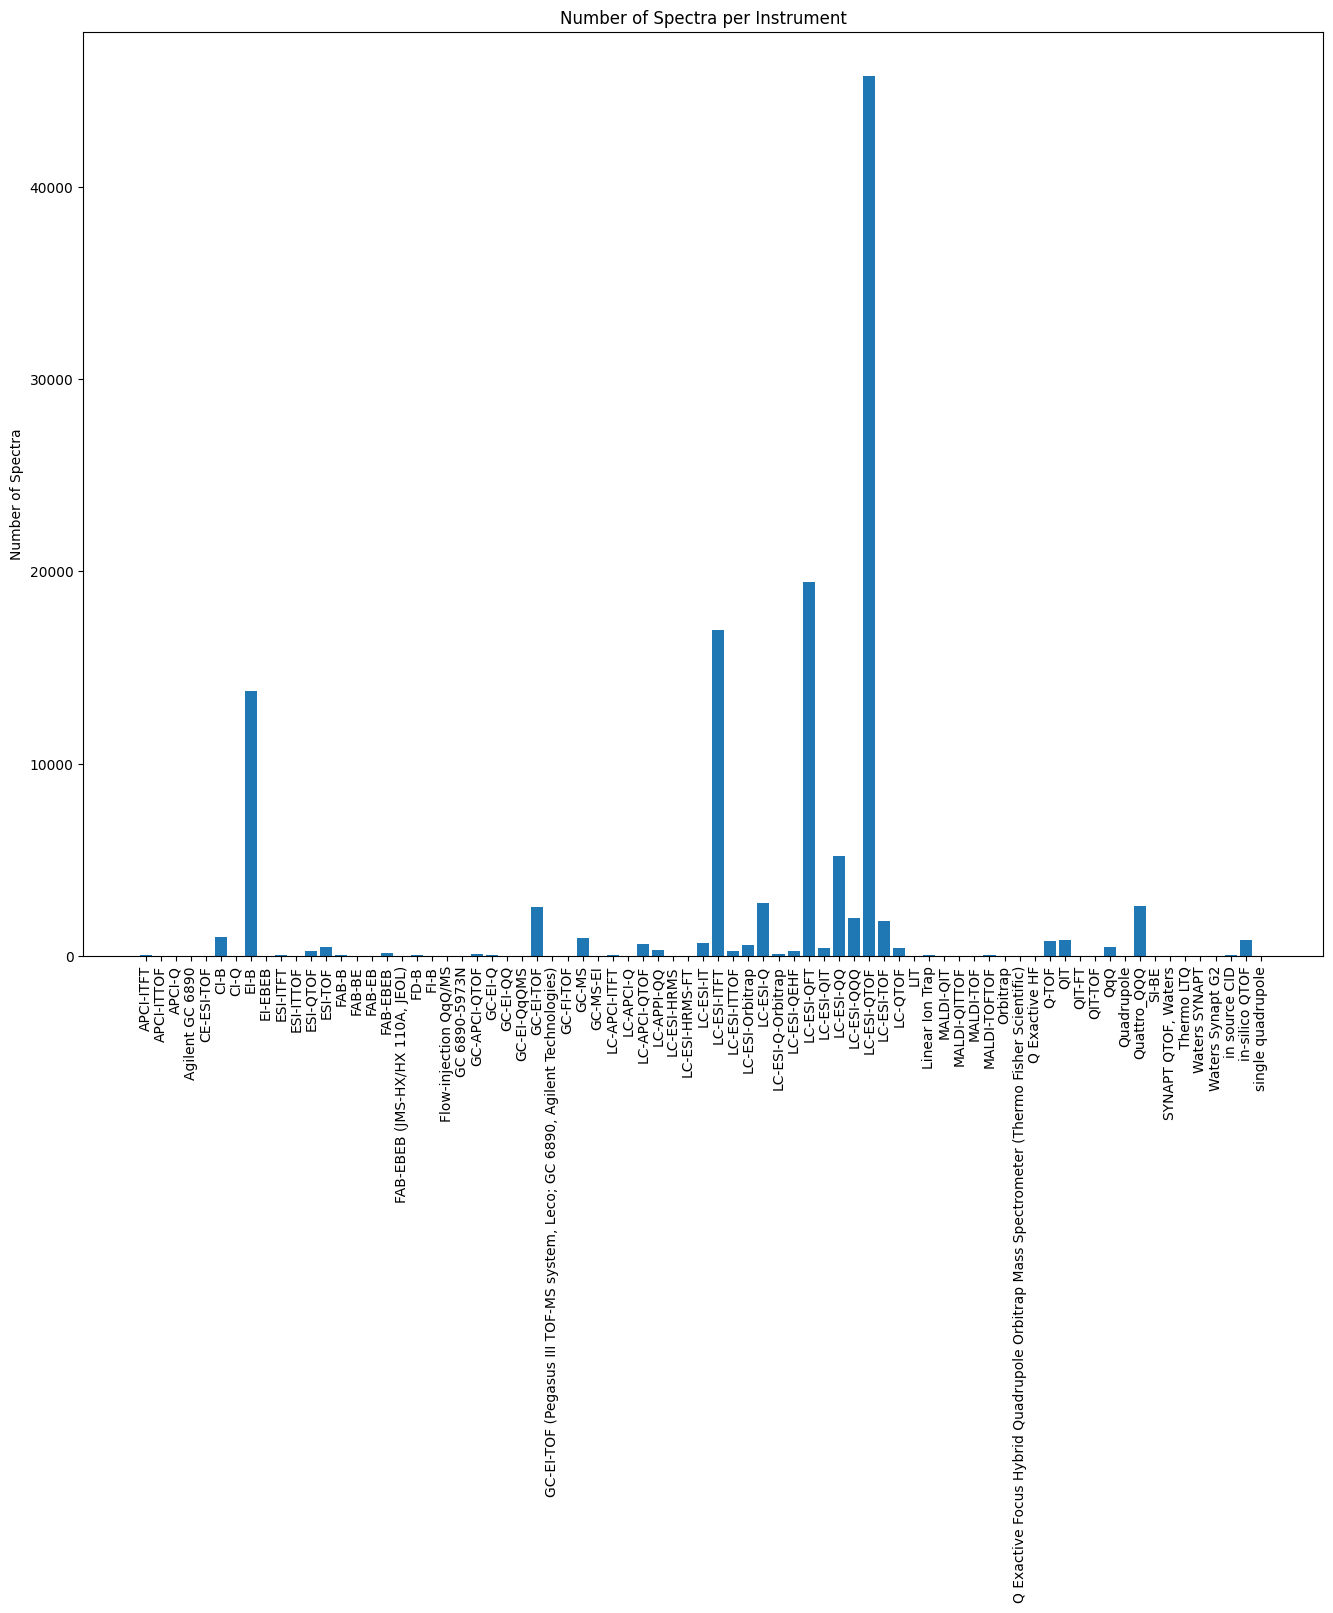

In [21]:
instruments = sorted(list(instrument_count_dict.keys()))
spectra_counts = [instrument_count_dict[instrument] for instrument in instruments]
plt.figure(figsize=(16,12))
plt.bar(instruments, spectra_counts)
plt.title('Number of Spectra per Instrument')
plt.ylabel('Number of Spectra')
plt.xticks(rotation = 90)
plt.show()